### 1. Load Train / Test / Validation Data Files

In [1]:
import numpy as np

In [2]:
train_features_path =  "../feature/ICDAR-RESNET-feature/train_features_triplet_loss.npy"
train_names_path = "../feature/ICDAR-RESNET-feature/train_names.npy"
train_labels_path = "../feature/ICDAR-RESNET-feature/train_labels.npy"

test_features_path = "../feature/ICDAR-RESNET-feature/test_features_triplet_loss.npy"
test_names_path = "../feature/ICDAR-RESNET-feature/test_names.npy"
test_labels_path = "../feature/ICDAR-RESNET-feature/test_labels.npy"

validation_features_path = "../feature/ICDAR-RESNET-feature/validation_features_triplet_loss.npy"
validation_names_path = "../feature/ICDAR-RESNET-feature/validation_names.npy"
validation_labels_path = "../feature/ICDAR-RESNET-feature/validation_labels.npy"

gallery_feature_path = "../feature/ICDAR-RESNET-feature/gallery_features_triplet_loss.npy"
gallery_name_path = "../feature/ICDAR-RESNET-feature/gallery_names.npy"

train_features = np.load(train_features_path)
train_names = np.load(train_names_path)
train_labels = np.load(train_labels_path)

test_features = np.load(test_features_path)
test_names = np.load(test_names_path)
test_labels = np.load(test_labels_path)

validation_features = np.load(validation_features_path)
validation_names = np.load(validation_names_path)
validation_labels = np.load(validation_labels_path)

gallery_features = np.load(gallery_feature_path)
gallery_names = np.load(gallery_name_path)

In [3]:
print(train_features.shape)
print(train_labels.shape)
print(train_names.shape)
print(test_features.shape)
print(test_labels.shape)
print(test_names.shape)
print(validation_features.shape)
print(validation_labels.shape)
print(validation_names.shape)
print(gallery_features.shape)
print(gallery_names.shape)

(857, 2048)
(857,)
(857,)
(401, 2048)
(401,)
(401,)
(391, 2048)
(391,)
(391,)
(64, 2048)
(64,)


In [4]:
def find_difference_vector(vector_features, vector_labels, vector_names, gallery_features, gallery_names):
    difference_vectors = []
    difference_names = []
    difference_labels = []

    for gallery_feature, gallery_name in zip(gallery_features, gallery_names):
        curr_difference_name = gallery_name
        curr_difference_feature = []
        curr_difference_label = []
        curr_difference = []
        
        for feature, name, label in zip(vector_features, vector_names, vector_labels):
            # print(f"Gallery Name: {gallery_name}, Name: {name}")
            if gallery_name == name:
                curr_difference_feature.append(feature)
                curr_difference_label.append(label)
        
        if curr_difference_feature:  # Check if the list is not empty
            # Assuming curr_difference_feature, curr_difference_label, and gallery_feature are numpy arrays
            curr_difference_feature = np.array(curr_difference_feature)
            curr_difference_label = np.array(curr_difference_label)
            curr_difference = curr_difference_feature - gallery_feature

            difference_vectors.append(curr_difference)
            difference_names.append(curr_difference_name)
            difference_labels.append(curr_difference_label)
            
    return difference_vectors, difference_names, difference_labels

In [5]:
test_difference_vectors, test_difference_names, test_difference_labels = find_difference_vector(test_features, test_labels, test_names, gallery_features, gallery_names)
train_difference_vectors, train_difference_names, train_difference_labels = find_difference_vector(train_features, train_labels, train_names, gallery_features, gallery_names)
validation_difference_vectors, validation_difference_names, validation_difference_labels = find_difference_vector(validation_features, validation_labels, validation_names, gallery_features, gallery_names)

### 2. Train on ANN

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

In [7]:
train_difference_vectors_flat = np.vstack(train_difference_vectors)
test_difference_vectors_flat = np.vstack(test_difference_vectors)
validation_difference_vectors_flat = np.vstack(validation_difference_vectors)

train_labels = np.vstack(train_labels)
test_labels = np.vstack(test_labels)
validation_labels = np.vstack(validation_labels)

In [8]:
scaler = StandardScaler()
train_difference_vectors_scaled = scaler.fit_transform(train_difference_vectors_flat)
test_difference_vectors_scaled = scaler.transform(test_difference_vectors_flat)
validation_difference_vectors_scaled = scaler.transform(validation_difference_vectors_flat)

In [9]:
def create_model(optimizer='adam', units1=128, units2=64, activation='relu'):
    model = Sequential()
    model.add(Dense(units=units1, input_shape=(train_difference_vectors_flat.shape[1],), activation=activation))
    model.add(Dense(units=units2, activation=activation))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [10]:
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=32, verbose=0)

In [11]:
model.fit(train_difference_vectors_scaled, train_labels)

c:\Users\Andreas Christianto\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


KerasClassifier(
	model=None
	build_fn=<function create_model at 0x000001A7AE4B8900>
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=32
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=10
	class_weight=None
)

In [12]:
model.model_.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 270593 (1.03 MB)
Trainable params: 270593 (1.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 3. Hyperparameter Tuning

In [13]:
params = model.get_params()

# Print the parameter keys and values
for key, value in params.items():
    print(f"{key}: {value}")


model: None
build_fn: <function create_model at 0x000001A7AE4B8900>
warm_start: False
random_state: None
optimizer: rmsprop
loss: None
metrics: None
batch_size: 32
validation_batch_size: None
verbose: 0
callbacks: None
validation_split: 0.0
shuffle: True
run_eagerly: False
epochs: 10
class_weight: None


In [14]:
param_grid = {'optimizer': ['adam', 'sgd', 'rmsprop'], 'batch_size': [16, 32, 64], 'epochs': [5, 10, 15]}

In [15]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')

In [16]:
grid_result = grid.fit(train_difference_vectors_scaled, train_labels)

c:\Users\Andreas Christianto\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


c:\Users\Andreas Christianto\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\Andreas Christianto\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\Andreas Christianto\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\Andreas Christianto\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will b

c:\Users\Andreas Christianto\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


c:\Users\Andreas Christianto\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\Andreas Christianto\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\Andreas Christianto\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\Andreas Christianto\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will b

In [17]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.882245 using {'batch_size': 32, 'epochs': 5, 'optimizer': 'sgd'}


### 4. Test

In [18]:
best_model = grid_result.best_estimator_
accuracy = best_model.score(test_difference_vectors_scaled, test_labels)
print(f"Accuracy on the test set: {accuracy}")

Accuracy on the test set: 0.940149625935162


### 5. ROC Curve

In [19]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

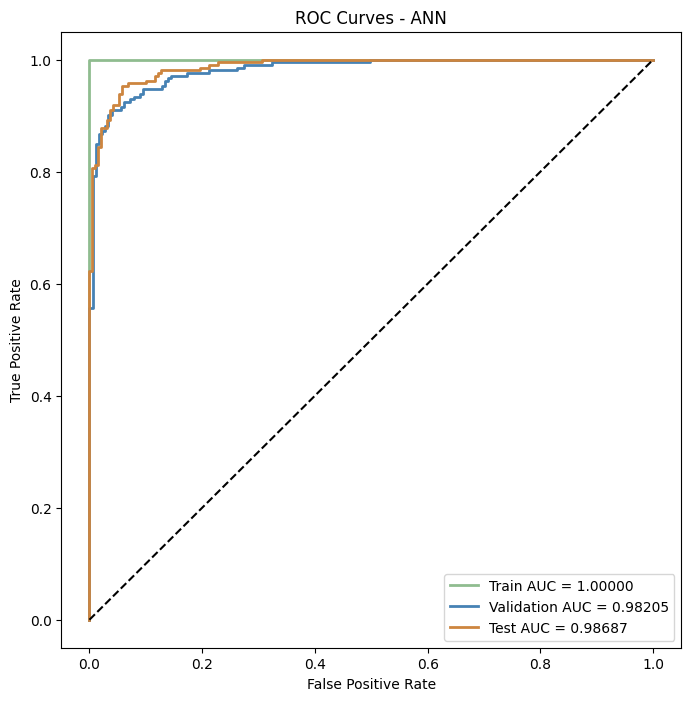

In [20]:
# Get predicted probabilities for each class on each dataset
y_train_prob = best_model.predict_proba(train_difference_vectors_scaled)[:, 1]
y_test_prob = best_model.predict_proba(test_difference_vectors_scaled)[:, 1]
y_val_prob = best_model.predict_proba(validation_difference_vectors_scaled)[:, 1]

fpr_test, tpr_test, _ = roc_curve(test_labels, y_test_prob)
roc_auc_test = auc(fpr_test, tpr_test)
fpr_train, tpr_train, _ = roc_curve(train_labels, y_train_prob)
roc_auc_train = auc(fpr_train, tpr_train)
fpr_val, tpr_val, _ = roc_curve(validation_labels, y_val_prob)
roc_auc_val = auc(fpr_val, tpr_val)

plt.figure(figsize=(8, 8))

plt.plot(fpr_train, tpr_train, color='darkseagreen', lw=2, label=f'Train AUC = {roc_auc_train:.5f}')
plt.plot(fpr_val, tpr_val, color='steelblue', lw=2, label=f'Validation AUC = {roc_auc_val:.5f}')
plt.plot(fpr_test, tpr_test, color='peru', lw=2, label=f'Test AUC = {roc_auc_test:.5f}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - ANN')
plt.legend()
plt.show()

In [21]:
def find_tpr_at_fpr(fpr, tpr, target_fpr):
    return np.interp(target_fpr, fpr, tpr)

In [22]:
target_fprs = [0.1, 0.01, 0.001]
tpr_at_target_fpr_train = [find_tpr_at_fpr(fpr_train, tpr_train, fpr) for fpr in target_fprs]
tpr_at_target_fpr_test = [find_tpr_at_fpr(fpr_test, tpr_test, fpr) for fpr in target_fprs]
tpr_at_target_fpr_val = [find_tpr_at_fpr(fpr_val, tpr_val, fpr) for fpr in target_fprs]

In [23]:
print(tpr_test)

[0.         0.00471698 0.02358491 0.62264151 0.62264151 0.80660377
 0.80660377 0.81132075 0.81132075 0.84433962 0.84433962 0.87735849
 0.87735849 0.89150943 0.89150943 0.91037736 0.91037736 0.91981132
 0.91981132 0.93867925 0.93867925 0.95283019 0.95283019 0.95754717
 0.95754717 0.96226415 0.96226415 0.97169811 0.97169811 0.97641509
 0.97641509 0.98113208 0.98113208 0.98584906 0.98584906 0.99056604
 0.99056604 0.99528302 0.99528302 1.         1.        ]


In [24]:
print(fpr_test)

[0.         0.         0.         0.         0.00529101 0.00529101
 0.01058201 0.01058201 0.01587302 0.01587302 0.02116402 0.02116402
 0.03174603 0.03174603 0.03703704 0.03703704 0.04232804 0.04232804
 0.05291005 0.05291005 0.05820106 0.05820106 0.06878307 0.06878307
 0.1005291  0.1005291  0.11640212 0.11640212 0.12169312 0.12169312
 0.12698413 0.12698413 0.1957672  0.1957672  0.21164021 0.21164021
 0.22751323 0.22751323 0.30687831 0.30687831 1.        ]


In [25]:
print("Train")
for tpr, fpr in zip(tpr_at_target_fpr_train, target_fprs):
    print(f'TPR at FPR {fpr:.3f}: {tpr:.3f}')
print(f'             AUC: {roc_auc_train}')

print("Validation")
for tpr, fpr in zip(tpr_at_target_fpr_val, target_fprs):
    print(f'TPR at FPR {fpr:.3f}: {tpr:.3f}')
print(f'             AUC: {roc_auc_val}')

print("Test")
for tpr, fpr in zip(tpr_at_target_fpr_test, target_fprs):
    print(f'TPR at FPR {fpr:.3f}: {tpr:.3f}')
print(f'             AUC: {roc_auc_test}')

Train
TPR at FPR 0.100: 1.000
TPR at FPR 0.010: 1.000
TPR at FPR 0.001: 1.000
             AUC: 1.0
Validation
TPR at FPR 0.100: 0.948
TPR at FPR 0.010: 0.792
TPR at FPR 0.001: 0.557
             AUC: 0.9820543902181933
Test
TPR at FPR 0.100: 0.958
TPR at FPR 0.010: 0.807
TPR at FPR 0.001: 0.623
             AUC: 0.9868723170609963
